## Import necessary libraries

In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [214]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [215]:
import plotly.express as px

## Data Cleaning Process

✅ No missing values found.
Failure Type
0    9652
1     112
2      78
3      95
4      18
5      45
Name: count, dtype: int64

🔍 Final Data Check:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               10000 non-null  int32  
 1   Type                     10000 non-null  int32  
 2   Air temperature [K]      10000 non-null  float64
 3   Process temperature [K]  10000 non-null  float64
 4   Rotational speed [rpm]   10000 non-null  int64  
 5   Torque [Nm]              10000 non-null  float64
 6   Tool wear [min]          10000 non-null  int64  
 7   Target                   10000 non-null  int64  
 8   Failure Type             10000 non-null  int64  
dtypes: float64(3), int32(2), int64(4)
memory usage: 625.1 KB
None


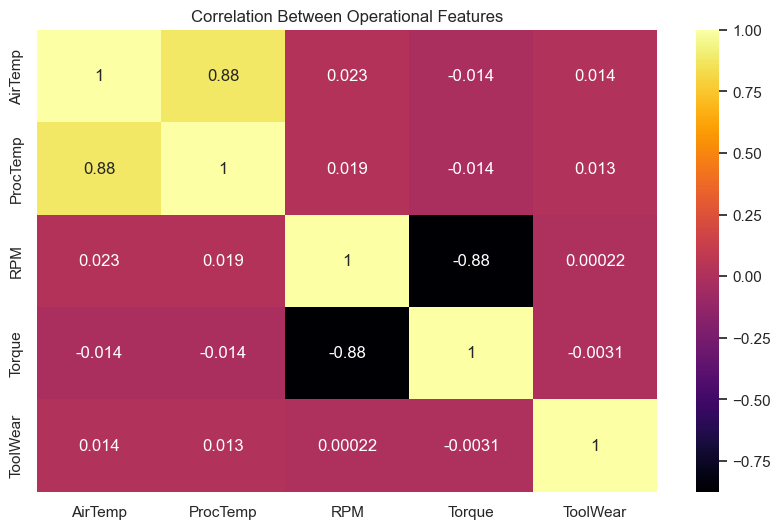


✅ Cleaned data saved as 'cleaned_data.csv'.


In [217]:
# Data Cleaning
# Load the dataset
df = pd.read_csv("C:/Users/Maya/OneDrive/Documents/Uni/Y2 S3/Data Science/assignment/predictive_maintenance.csv")
np.random.seed(0)

# 1. Drop UDI because it is not used and destroys model efficiency -------------------------------------
df.drop(columns=['UDI'], inplace=True)

# 2. Check for Missing Values ----------------------------------------
missing_values = df.isnull().sum()
if missing_values.sum() == 0:
    print("✅ No missing values found.")
else:
    print("⚠️ Missing values detected:\n", missing_values)

# 3. Encode Categorical Features -------------------------------------
# Alphabetically
label_enc = LabelEncoder()

# Encoding Product ID
df['Product ID'] = label_enc.fit_transform(df['Product ID'])

# Encoding Type and Failure Type
df['Type'] = label_enc.fit_transform(df['Type'])
# df['Failure Type'] = label_enc.fit_transform(df['Failure Type'])

# Define your custom mapping (No Failure first)
failure_mapping = {
    'No Failure': 0,
    'Heat Dissipation Failure': 1,
    'Overstrain Failure': 2,
    'Power Failure': 3,
    'Random Failures': 4,
    'Tool Wear Failure': 5
}

# Apply mapping
df['Failure Type'] = df['Failure Type'].map(failure_mapping)

# Verify
print(df['Failure Type'].value_counts().sort_index())
      
# 4. Standardizing Numerical Features -------------------------------
scaler = StandardScaler()

# 5. Final Data Check -----------------------------------------------
print("\n🔍 Final Data Check:")
print(df.info())

# 6. Heatmap ----------------------------------------
# Load the dataset
df = pd.read_csv("cleaned_data.csv")

# Rename columns for easier access
df.rename(columns={
    "Air temperature [K]": "AirTemp",
    "Process temperature [K]": "ProcTemp",
    "Rotational speed [rpm]": "RPM",
    "Torque [Nm]": "Torque",
    "Tool wear [min]": "ToolWear",
    "Failure Type": "FailureType",
    "Type": "MachineType"
}, inplace=True)

# Plot correlation heatmap between operational variables and failure type
plt.figure(figsize=(10, 6))
corr = df[['AirTemp', 'ProcTemp', 'RPM', 'Torque', 'ToolWear']].corr()
sns.heatmap(corr, annot=True, cmap='inferno')
plt.title("Correlation Between Operational Features")
plt.show()

# Save cleaned data
df.to_csv("cleaned_data.csv", index=False)
print("\n✅ Cleaned data saved as 'cleaned_data.csv'.")

In [218]:
# Check for failure types, make sure to un-comment the code in the previous section first
print("Categories in order:", label_enc.classes_)

Categories in order: ['H' 'L' 'M']


## Data Preprocessing for Machine Learning
Prepares dataset for predictive modelling.

In [220]:
# Define features and target
X = df.drop(columns=['Target'])  # Features
y = df['Target']                 # Target label (0 = No Failure, 1 = Failure)

# Scale the features for models that are sensitive to feature scales (like SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## 📌 For reference
    No Failure: 0
    Heat Dissipation Failure: 1
    Overstrain Failure: 2
    Power Failure: 3
    Random Failures: 4
    Tool Wear Failure: 5


## **Question 1:** What are the patterns and distributions of machine failure types observed under different operational conditions such as tool wear, temperature, and torque ?

### Boxplots: Operational Variable vs Failure Type 

To explore how operational conditions vary across different machine failure types, boxplots were used to visualize the distribution of each numerical feature — Tool Wear, Air Temperature, Process Temperature, Torque, and RPM — for each failure category.

These boxplots help identify potential patterns or outliers that could indicate a relationship between machine condition and failure type.

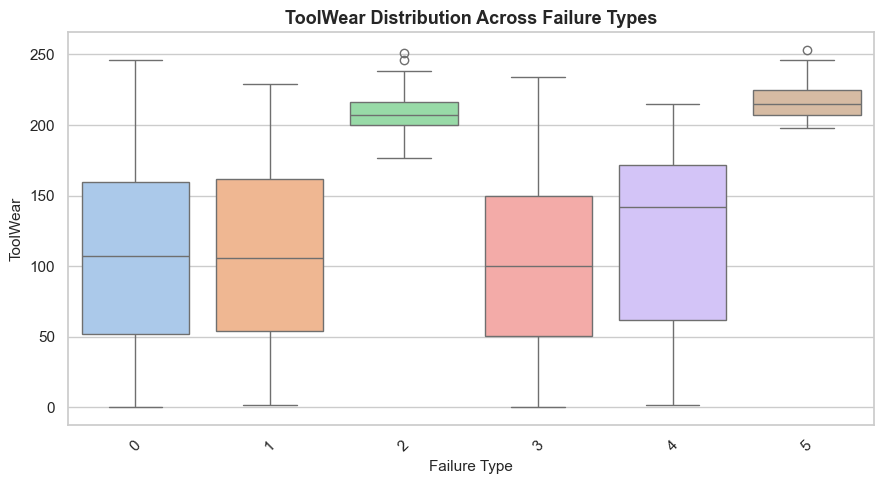

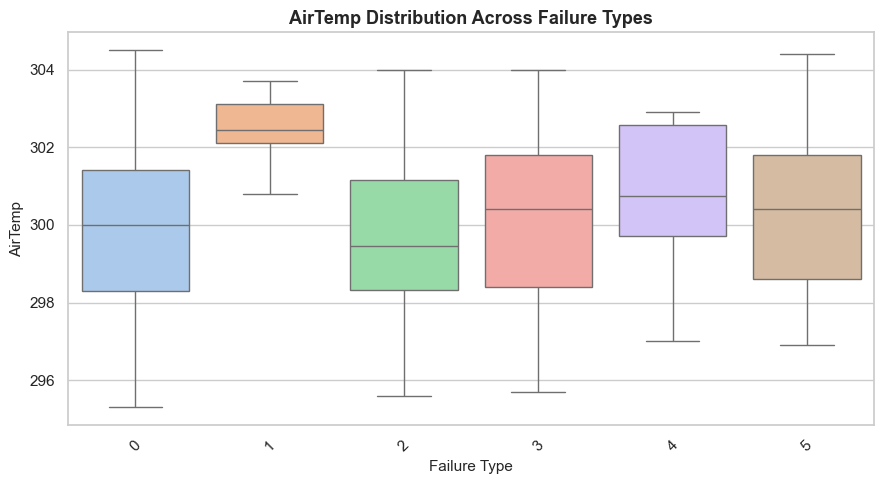

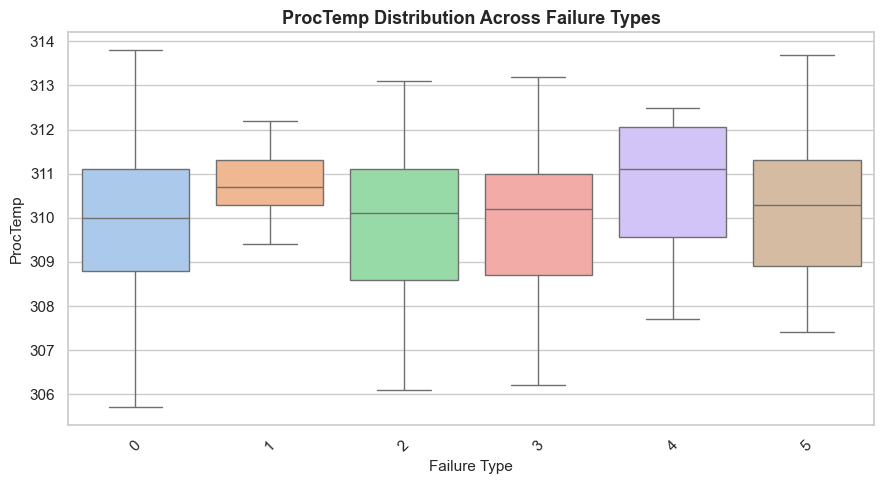

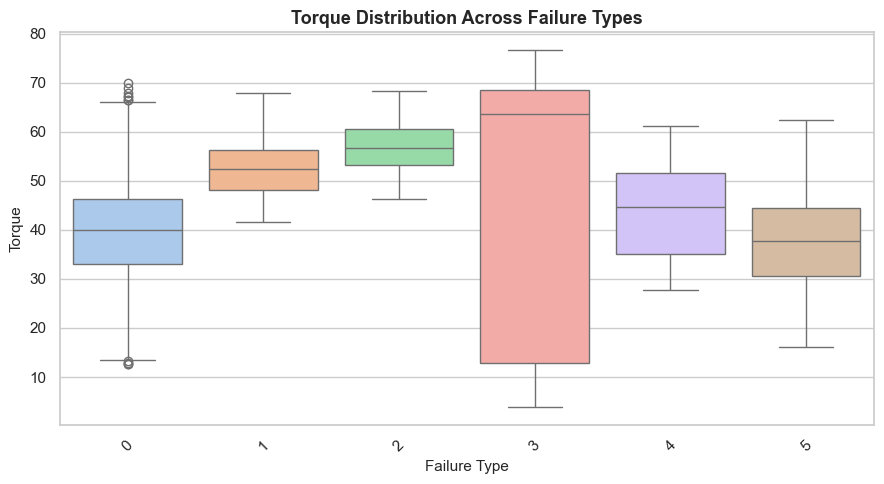

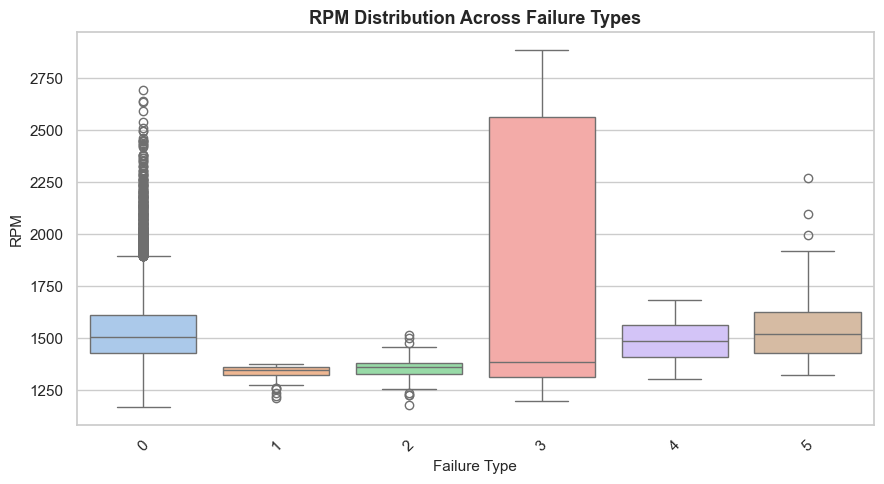

In [225]:
# --- Boxplots: Failure Type vs Operational Variables ---
for feature in ['ToolWear', 'AirTemp', 'ProcTemp', 'Torque', 'RPM']:
    plt.figure(figsize=(9, 5))
    sns.boxplot(data=df, x='FailureType', y=feature, hue='FailureType', palette="pastel", legend=False)
    plt.title(f"{feature} Distribution Across Failure Types", fontsize=13, weight='bold')
    plt.xlabel("Failure Type", fontsize=11)
    plt.ylabel(feature, fontsize=11)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Boxplot Analysis: Operational Variables vs. Failure Types

The following boxplots visualize how each operational variable (**ToolWear**, **AirTemp**, **ProcTemp**, **Torque**, and **RPM**) is distributed across different machine failure types. This helps in understanding which features may be associated with specific failures, potentially offering insights for predictive maintenance strategies.

| Feature     | Key Observations |
|-------------|------------------|
| **ToolWear** | *Failure Type 5* (*Tool Wear Failure*) shows high tool wear values, while other failure types show more varied or lower distributions. |
| **AirTemp**  | Minor differences in temperature across failure types, but generally within a narrow range. No obvious outlier for a specific failure type. |
| **ProcTemp** | Slight upward trend in process temperature for certain failures (e.g., *Failure Type 4* and *5*), but variation is minimal. |
| **Torque**   | *Failure Type 3* (*Power Failure*) has lower torque values, while other failures are more centered or higher. |
| **RPM**      | *Failure Type 3* (*Power Failure*) shows wider distribution with higher RPM values; most other types have tightly clustered RPMs. |

---

### Analysis of the Boxplots

Based on the boxplots, we can see that:

- **ToolWear:** Machines labeled as *Failure Type 5* (*Tool Wear Failure*) have significantly higher tool wear compared to other failure types, as expected. This suggests that **ToolWear** is a direct contributor to this failure mode.

- **Torque:** *Failure Type 3* (*Power Failure*) shows the lowest range of **Torque**, distinguishing it from other failure types with moderate to high values. **Torque** appears to play a critical role in this type of failure.

- **RPM:** *Failure Type 3* also stands out with higher variability and occasional extreme **RPM** values. This may indicate instability in rotational speed contributing to *Power Failures*.

- **AirTemp & ProcTemp:** These temperature features show relatively small differences across failure types. There is no strong evidence that they are useful for distinguishing failure categories on their own.

---

### Conclusion

Boxplot visualizations suggest that some operational variables, particularly **ToolWear** and **Torque**, have meaningful variation across failure types, which could be used for failure prediction. However, other variables like temperature show limited discriminatory power. To gain more actionable insights, these visual cues should be paired with statistical testing and incorporated into multivariate classification models for predictive maintenance in industrial systems.


### Countplot: Machine Type vs Failure Type

To explore how machine design complexity relates to the types of failures experienced, a countplot was created to show the frequency distribution of each failure type across the three machine categories — Low (0), Medium (1), and High (2) complexity.

This visualization helps identify whether certain machine types are more prone to specific failures, providing insight into design vulnerabilities or operational risks associated with different machine complexities.


In [228]:
import plotly.express as px

# Reverse mapping
failure_name_mapping = {v: k for k, v in failure_mapping.items()}

# Map failure names
df['FailureType_Name'] = df['FailureType'].map(failure_name_mapping)

# Plot
fig = px.histogram(
    df,
    x='MachineType',
    color='FailureType_Name',
    barmode='group',
    color_discrete_sequence=px.colors.qualitative.Set2,
    title="Distribution of Failure Types by Machine Type",
    labels={
        'MachineType': 'Machine Type',
        'count': 'Count',
        'FailureType_Name': 'Failure Type'
    },
    width=900,
    height=600,
    category_orders={"FailureType_Name": list(failure_mapping.keys())}
)

# Layout updates
fig.update_layout(
    title_font=dict(size=18, family='Arial', color='black'),
    xaxis_title_font=dict(size=14),
    yaxis_title_font=dict(size=14),
    legend_title_text='Failure Type',
    legend=dict(font=dict(size=12)),
    hovermode='x unified',
    hoverlabel=dict(font_size=12)
)

# Hover info
fig.update_traces(
    hovertemplate="<b>%{x}</b><br>Failure Type: %{fullData.name}<br>Count: %{y}<extra></extra>"
)

# Add side annotation for Machine Type explanation
fig.add_annotation(
    xref="paper", yref="paper",
    x=1, y=1,
    text="<b>Machine Type</b><br>0 - Low Complexity<br>1 - Medium Complexity<br>2 - High Complexity",
    showarrow=False,
    align='left',
    font=dict(size=12),
    bordercolor="black",
    borderwidth=1,
    borderpad=5,
    bgcolor="LightYellow",
    opacity=0.9
)

fig.show()

### Countplot Analysis: Distribution of Failure Types by Machine Type

The following **countplot** visualizes how different failure types are distributed across machine types categorized by their complexity level: **Low (0)**, **Medium (1)**, and **High (2)**. This plot helps identify whether specific machine types are more prone to certain failures, offering insight into design-related failure patterns.

| Machine Type        | Key Observations |
|---------------------|------------------|
| **0 – Low Complexity**    | Majority of records show **No Failure** (~1000 instances). Very few occurrences of any failure type. |
| **1 – Medium Complexity** | Still mostly **No Failure**, but there’s a slight increase in **Tool Wear**, **Power**, and **Overstrain Failures**. |
| **2 – High Complexity**   | Significantly higher total count (~3000+). Also, notably higher counts of **Power Failures**, **Heat Dissipation Failures**, and **Tool Wear Failures**. |

---

### Analysis of the Countplot

Based on the countplot, we can see that:

- **Failure Frequency and Complexity:** Machines with **higher complexity (Type 2)** experience more frequent and varied failures, especially **Tool Wear** and **Power Failures**. This indicates that complex machines might be more susceptible to breakdowns under demanding conditions.

- **No Failure Still Dominant:** Across all machine types, the **No Failure** category is the most frequent, suggesting that failures are still relatively rare events in the dataset.

- **Low Complexity Machines Are Most Reliable:** Machines labeled as **Type 0** report the fewest failures overall, indicating higher reliability or more controlled operating environments.

---

### Conclusion

The countplot analysis reveals a clear trend between **machine complexity and failure types**. Higher complexity machines are linked to more frequent and varied failures. These insights highlight the need for **complexity-aware maintenance strategies**, especially for systems operating under high-load or precision-dependent conditions.


### One-Way ANOVA Test: Operational Features Across Failure Types

To explore whether different types of machine failures are associated with distinct operational conditions, a one-way ANOVA test was conducted for each numerical feature — Air Temperature, Process Temperature, RPM, Torque, and Tool Wear — across the various failure categories.

This statistical approach helps determine if the mean values of these operational variables significantly differ between failure types, providing evidence of potential relationships that could inform predictive maintenance strategies.


In [231]:
from scipy.stats import f_oneway

# Define the numerical features to test
features = ['AirTemp', 'ProcTemp', 'RPM', 'Torque', 'ToolWear']

# Perform one-way ANOVA: does the mean of each feature differ by failure type?
for feature in features:
    groups = [df[df['FailureType'] == i][feature] for i in df['FailureType'].unique()]
    f_val, p_val = f_oneway(*groups)
    print(f'{feature}: F={f_val:.2f}, p={p_val:.4f}')

AirTemp: F=38.79, p=0.0000
ProcTemp: F=7.60, p=0.0000
RPM: F=78.21, p=0.0000
Torque: F=104.40, p=0.0000
ToolWear: F=68.19, p=0.0000


### ANOVA Analysis: Operational Feature Differences Across Failure Types

The following table summarizes the results of a **One-Way ANOVA (Analysis of Variance)** test performed on each operational feature to determine whether the mean values differ significantly across machine failure types. This helps identify which operational conditions are most associated with distinct failure behaviors.

| Feature     | F-Statistic | p-value  | Significance |
|-------------|-------------|----------|--------------|
| **AirTemp** | 38.79       | 0.0000   | Significant  |
| **ProcTemp**| 7.60        | 0.0000   | Significant  |
| **RPM**     | 78.21       | 0.0000   | Significant  |
| **Torque**  | 104.40      | 0.0000   | Significant  |
| **ToolWear**| 68.19       | 0.0000   | Significant  |

---

### Analysis of the ANOVA Results

Based on the ANOVA test results:

- All tested features have **p-values < 0.05**, indicating that the differences in their means across failure types are **statistically significant**.

- **Torque** and **RPM** exhibit the **highest F-statistics**, suggesting they contribute the most variance between failure groups and could be strong predictors of failure types.

- **ToolWear** and **AirTemp** also show significant between-group differences, making them relevant operational indicators.

- **ProcTemp**, while statistically significant, has the **lowest F-value**, implying a more modest effect across failure categories.

---

### Conclusion

The ANOVA analysis confirms that operational conditions such as **Torque, RPM, and ToolWear** vary significantly across different failure types. These variables are likely to play a key role in failure classification and should be prioritized during feature selection. These insights validate the presence of measurable patterns between machine state and failure behavior, which can be leveraged in predictive maintenance models.


---

### Final Conclusion

Through visual and statistical analysis, several patterns emerged linking operational variables to specific failure types. Notably, ToolWear and Torque were strongly associated with Tool Wear and Power Failures respectively. Machines with higher complexity (Type 2) experienced the highest frequency and diversity of failures. ANOVA results further confirmed that all five operational variables showed statistically significant differences across failure types.

These findings support the feasibility of using operational data to build predictive models for machine failure, and they highlight the need for targeted maintenance strategies based on machine complexity and sensor readings.


## **Question 2:** Does tool wear increase the likelihood of machine failure, and is there a critical threshold where failure risk spikes?

### Quantify whether some machine types fail more often

For reference, here is the label encoding map for machine type.

| Encoded | Original |
| ------- | -------- |
| 0       | H        |
| 1       | L        |
| 2       | M        |

But for simplicity's sake, it will be reversed so the original labels will be used for visualisations; making it more interpretable and easier to glance at.

In [237]:
# Reverse encoding
df['OriginalType'] = label_enc.inverse_transform(df['MachineType'])

failure_by_type = df.groupby("OriginalType")["Target"].mean().reset_index()
failure_by_type.columns = ["MachineType", "FailureRate"]
print(failure_by_type)

  MachineType  FailureRate
0           H     0.020937
1           L     0.039167
2           M     0.027694


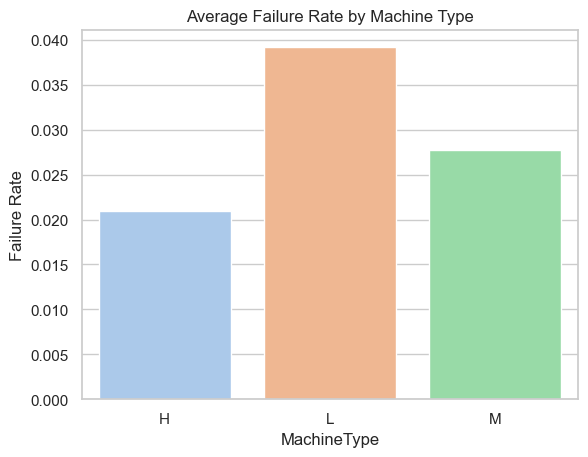

In [238]:
sns.barplot(data=failure_by_type, x="MachineType", y="FailureRate", hue="MachineType", palette="pastel", legend=False)
plt.title("Average Failure Rate by Machine Type")
plt.ylabel("Failure Rate")
plt.show()

Based on the barchart, Type L has a higher likelihood of failing overall.

### Checking Statistical Significance using Chi-Square Test

The objective of the test is to determine whether failure occurrence (Target: 1 or 0) is independent of machine type (L, M, H)

- **Null hypothesis (H₀):** Machine type and failure occurrence are independent (i.e., machine type does not affect failure rate).
- **Alternative hypothesis (H₁):** There is a relationship between machine type and failure occurrence.

In [241]:
import scipy.stats as stats

# Contingency table of failures by type
contingency = pd.crosstab(df['MachineType'], df['Target'])
chi2, p, dof, expected = stats.chi2_contingency(contingency)

print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p:.4f}")

Chi-square statistic: 13.75
p-value: 0.0010


Since p-value < 0.05, null hypothesis is **rejected**.

#### Therefore, Machine type does influence the likelihood of failure — some types fail more often than others.

### Logistic Regression

Now that association does exist between machine type and failure, the next step is:
- To determine how much of this is due to machine type itself
- Whether it's still significant afte accounting for operational conditions like torque, temperature, RPM, etc.

In [244]:
import statsmodels.api as sm

# Create dummy variables for MachineType (we drop one to avoid multicollinearity)
# Type L is dropped and used as the baseline.
df['Type_H'] = (df['MachineType'] == 0).astype(int)
df['Type_L'] = (df['MachineType'] == 1).astype(int)  # Baseline
df['Type_M'] = (df['MachineType'] == 2).astype(int)

In [245]:
# Define features and target
features = ['AirTemp', 'ProcTemp', 'RPM', 'Torque', 'ToolWear', 'Type_H', 'Type_M']
X = df[features]
y = df['Target']

# Add intercept
X = sm.add_constant(X)

# Fit the model
model = sm.Logit(y, X).fit()

# Show model summary
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.095696
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                 Target   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9992
Method:                           MLE   Df Model:                            7
Date:                Fri, 20 Jun 2025   Pseudo R-squ.:                  0.3536
Time:                        04:32:58   Log-Likelihood:                -956.96
converged:                       True   LL-Null:                       -1480.5
Covariance Type:            nonrobust   LLR p-value:                8.286e-222
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -36.4178     14.662     -2.484      0.013     -65.156      -7.680
AirTemp        0.7700      0

| Variable                                                                   | Coef   | p-value | Interpretation                                    |
| -------------------------------------------------------------------------- | ------ | ------- | ------------------------------------------------- |
| **Type\_H**                                                                | -0.596 | 0.023   | **Significantly less likely** to fail than Type L |
| **Type\_M**                                                                | -0.318 | 0.032   | **Also less likely** to fail than Type L          |

p-values < 0.05 means statistically significant effect of machine type.   

### Conclusion
#### The logistic regression model shows that machine type has a statistically significant effect on machine failure, even when accounting for operating conditions. Based on the table, machines that are Type L are more likely to fail compared to Type H and Type M machines. This suggests that the design or usage differences across machine types play a role in failure risk.

## **Question 3:** Can machine learning models (e.g., Random Forest, SVM, XGBoost) accurately predict machine failures based on real-time sensor data?

In [248]:
# Question 3 (Damia)

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Initialize and train the models

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Support Vector Machine
svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# XGBoost
xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [249]:
from sklearn.metrics import accuracy_score, classification_report

# Evaluate models using accuracy, precision, recall, and F1-score

# Create a function to extract model performance
def extract_performance(y_test, y_pred, model_name):
    report = classification_report(y_test, y_pred, output_dict=True)
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-Score": report["1"]["f1-score"]
    }

# Compile performance metrics
results = {
    "Random Forest": extract_performance(y_test, y_pred_rf, "Random Forest"),
    "SVM": extract_performance(y_test, y_pred_svm, "SVM"),
    "XGBoost": extract_performance(y_test, y_pred_xgb, "XGBoost")
}

# Display results
pd.DataFrame(results).T

,Accuracy,Precision,Recall,F1-Score
Random Forest,0.9975,0.951613,0.967213,0.959350
SVM,0.9980,0.967213,0.967213,0.967213
XGBoost,0.9990,1.000000,0.967213,0.983333


## **Question 4:** Based on sensor readings (Tool Wear, Torque, Temperature), what are the most critical threshold values that indicate a high risk of machine failure, and how can these be used to guide preventive maintenance decisions?

C:\Users\Maya\AppData\Local\Temp\ipykernel_19816\3202471334.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Maya\AppData\Local\Temp\ipykernel_19816\3202471334.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




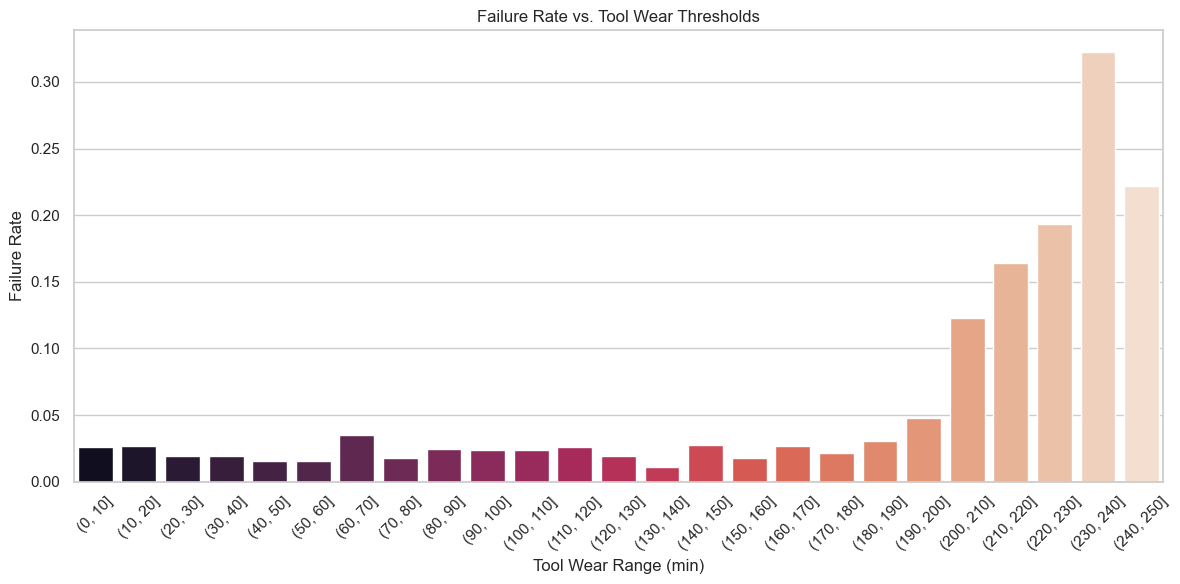

   Tool Wear Range  Failure Rate
0          (0, 10]      0.025882
1         (10, 20]      0.027140
2         (20, 30]      0.019651
3         (30, 40]      0.019608
4         (40, 50]      0.015385
5         (50, 60]      0.015385
6         (60, 70]      0.035011
7         (70, 80]      0.017505
8         (80, 90]      0.024609
9        (90, 100]      0.024176
10      (100, 110]      0.024176
11      (110, 120]      0.025751
12      (120, 130]      0.019608
13      (130, 140]      0.011161
14      (140, 150]      0.027837
15      (150, 160]      0.017778
16      (160, 170]      0.027149
17      (170, 180]      0.021368
18      (180, 190]      0.030769
19      (190, 200]      0.047722
20      (200, 210]      0.122850
21      (210, 220]      0.164444
22      (220, 230]      0.193182
23      (230, 240]      0.322581
24      (240, 250]      0.222222


In [251]:
# Question 4 (Lycia)

# Load the cleaned dataset
df = pd.read_csv("dataclean.csv")  # Make sure this path is correct in your notebook

# Step 1: Create bins for tool wear
df['Tool wear bin'] = pd.cut(df['Tool wear [min]'], bins=np.arange(0, 260, 10))

# Step 2: Calculate failure rate per bin
threshold_analysis = df.groupby('Tool wear bin')['Target'].mean().reset_index()
threshold_analysis.columns = ['Tool Wear Range', 'Failure Rate']

# Step 3: Plot failure rate vs. tool wear range
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.barplot(x='Tool Wear Range', y='Failure Rate', data=threshold_analysis, palette="rocket")

# Step 4: Final plot adjustments
plt.xticks(rotation=45)
plt.title("Failure Rate vs. Tool Wear Thresholds")
plt.xlabel("Tool Wear Range (min)")
plt.ylabel("Failure Rate")
plt.tight_layout()
plt.show()

# Optional: Display the table of results
print(threshold_analysis)

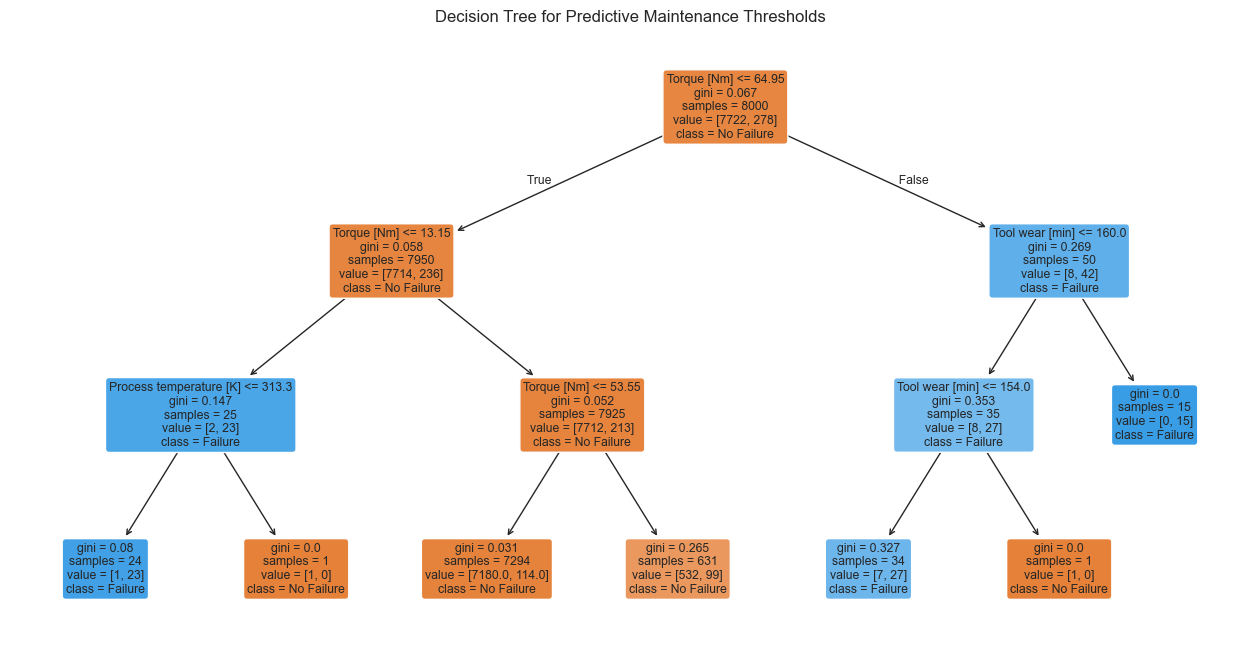

              precision    recall  f1-score   support

  No Failure       0.98      1.00      0.99      1939
     Failure       0.79      0.25      0.38        61

    accuracy                           0.97      2000
   macro avg       0.88      0.62      0.68      2000
weighted avg       0.97      0.97      0.97      2000



In [252]:
# Select key sensor features and target
features = ['Tool wear [min]', 'Torque [Nm]', 'Air temperature [K]', 'Process temperature [K]']
X = df[features]
y = df['Target']

# Step 1: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Train Decision Tree model
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

# Step 3: Plot the decision tree
plt.figure(figsize=(16, 8))
plot_tree(tree_model, feature_names=features, class_names=["No Failure", "Failure"],
          filled=True, rounded=True)
plt.title("Decision Tree for Predictive Maintenance Thresholds")
plt.show()

# Step 4: Classification performance
y_pred = tree_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=["No Failure", "Failure"])
print(report)

Classification Report:
               precision    recall  f1-score   support

  No Failure       0.98      1.00      0.99      1939
     Failure       0.80      0.26      0.40        61

    accuracy                           0.98      2000
   macro avg       0.89      0.63      0.69      2000
weighted avg       0.97      0.98      0.97      2000



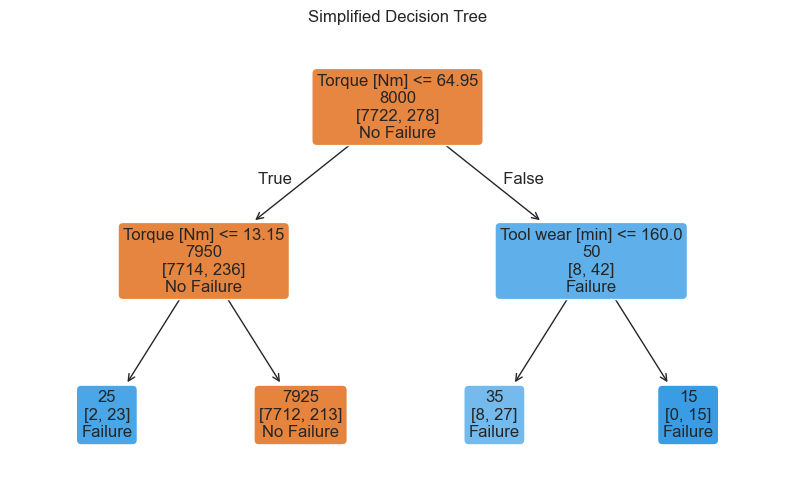

In [253]:
# Step 1: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Train a simple Decision Tree
tree_model = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_model.fit(X_train, y_train)

# Step 3: Evaluate performance
y_pred = tree_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["No Failure", "Failure"]))

# Step 4: Plot the tree (no gini, no value, no samples)
plt.figure(figsize=(10, 6))
plot_tree(
    tree_model,
    feature_names=features,
    class_names=["No Failure", "Failure"],
    filled=True,
    rounded=True,
    impurity=False,   
    proportion=False,  
    label='none',        # ❌ Removes "gini" and "samples" labels
    fontsize=12  
         
)
plt.title("Simplified Decision Tree")
plt.show()